In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# -----------------------------
# Neural Network Configuration
# -----------------------------
INPUT_SIZE = 784
HIDDEN_SIZE = 32
OUTPUT_SIZE = 10

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def one_hot(y):
    enc = OneHotEncoder(sparse_output=False)
    return enc.fit_transform(y.reshape(-1, 1))

# -----------------------------
# Neural Network Forward Pass
# -----------------------------
def decode_weights(vector):
    idx = 0
    w1_size = INPUT_SIZE * HIDDEN_SIZE
    b1_size = HIDDEN_SIZE
    w2_size = HIDDEN_SIZE * OUTPUT_SIZE
    b2_size = OUTPUT_SIZE

    w1 = vector[idx:idx + w1_size].reshape(INPUT_SIZE, HIDDEN_SIZE)
    idx += w1_size
    b1 = vector[idx:idx + b1_size]
    idx += b1_size
    w2 = vector[idx:idx + w2_size].reshape(HIDDEN_SIZE, OUTPUT_SIZE)
    idx += w2_size
    b2 = vector[idx:idx + b2_size]

    return w1, b1, w2, b2

def forward_pass(X, vector):
    w1, b1, w2, b2 = decode_weights(vector)
    hidden = sigmoid(X @ w1 + b1)
    output = softmax(hidden @ w2 + b2)
    return output

def fitness(vector, X, y_true):
    y_pred = forward_pass(X, vector)
    return log_loss(y_true, y_pred)

# -----------------------------
# Differential Evolution
# -----------------------------
def differential_evolution(fitness_func, bounds, X, y_true, NP=10, F=0.9, CR=0.4, generations=500):
    D = len(bounds)
    
    
    pop = np.random.uniform(-0.5, 0.5, (NP, D))     # population with uniform distribution

    

    input_dim = 28*28
    output_dim = 10
    # scalling
    
    xavier_scaling = np.sqrt(6.0 / (input_dim + output_dim))
    print(xavier_scaling)
    pop = np.random.uniform(-xavier_scaling, xavier_scaling, (NP, D))
    
    for i in range(D):
        pop[:, i] = bounds[i][0] + (pop[:, i] - pop.min()) * (bounds[i][1] - bounds[i][0]) / (pop.max() - pop.min())

    fitness_scores = np.array([fitness_func(ind, X, y_true) for ind in pop])
    best_idx = np.argmin(fitness_scores)

    for gen in range(generations):
        for i in range(NP):
            idxs = [idx for idx in range(NP) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = pop[i] + F * (pop[best_idx] - pop[i]) + F * (b - c)
            mutant = np.clip(mutant, -1, 1)
            cross_points = np.random.rand(D) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, D)] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_fitness = fitness_func(trial, X, y_true)

            if trial_fitness < fitness_scores[i]:
                pop[i] = trial
                fitness_scores[i] = trial_fitness
                if trial_fitness < fitness_scores[best_idx]:
                    best_idx = i

        print(f"Generation {gen+1}, Best Fitness: {fitness_scores[best_idx]:.4f}")

    return pop[best_idx]
# -----------------------------
# Main Workflow
# -----------------------------
mnist = fetch_openml('mnist_784', version=1)
X = StandardScaler().fit_transform(mnist.data / 255.0)
y = one_hot(np.array(mnist.target, dtype=int))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a subset for DE due to computational cost
X_train = X_train[:1000]
y_train = y_train[:1000]
X_test = X_test[:2000]
y_test = y_test[:2000]

# Total number of weights and biases
dimension = INPUT_SIZE * HIDDEN_SIZE + HIDDEN_SIZE + HIDDEN_SIZE * OUTPUT_SIZE + OUTPUT_SIZE
bounds = [(-1, 1)] * dimension

best_weights = differential_evolution(fitness, bounds, X_train, y_train)
y_pred = forward_pass(X_test, best_weights)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)

print(f"Test Accuracy on MNIST subset: {accuracy:.4f}")

0.0869291381699617
Generation 1, Best Fitness: 2.2816
Generation 2, Best Fitness: 2.2782
Generation 3, Best Fitness: 2.2782
Generation 4, Best Fitness: 2.2650
Generation 5, Best Fitness: 2.2487
Generation 6, Best Fitness: 2.2487
Generation 7, Best Fitness: 2.2487
Generation 8, Best Fitness: 2.2367
Generation 9, Best Fitness: 2.2367
Generation 10, Best Fitness: 2.2367
Generation 11, Best Fitness: 2.2367
Generation 12, Best Fitness: 2.2367
Generation 13, Best Fitness: 2.2367
Generation 14, Best Fitness: 2.2367
Generation 15, Best Fitness: 2.2367
Generation 16, Best Fitness: 2.2367
Generation 17, Best Fitness: 2.2367
Generation 18, Best Fitness: 2.2367
Generation 19, Best Fitness: 2.2367
Generation 20, Best Fitness: 2.2367
Generation 21, Best Fitness: 2.2367
Generation 22, Best Fitness: 2.2367
Generation 23, Best Fitness: 2.2367
Generation 24, Best Fitness: 2.2202
Generation 25, Best Fitness: 2.2202
Generation 26, Best Fitness: 2.2202
Generation 27, Best Fitness: 2.2202
Generation 28, Bes

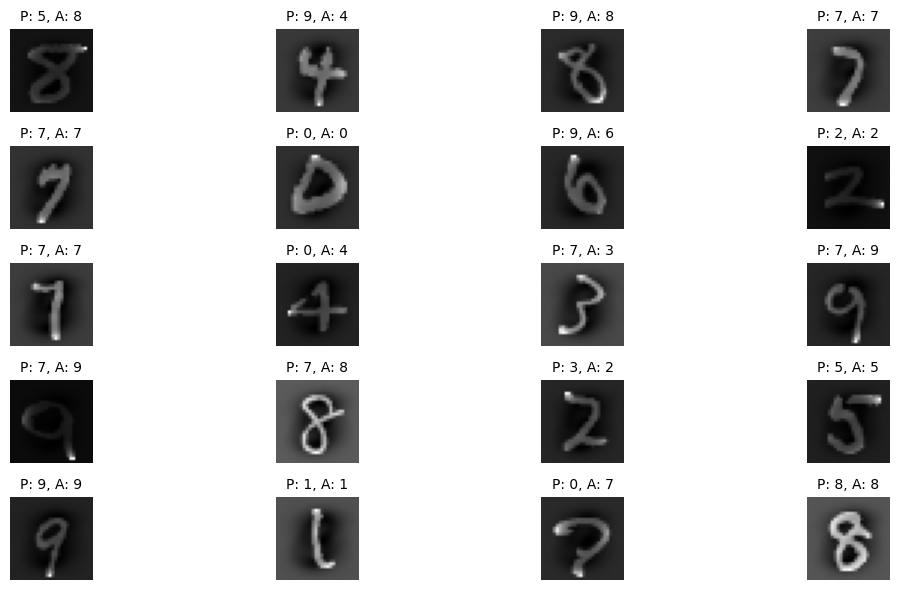

In [2]:
# -----------------------------
# Show Multiple Test Sample Predictions
# -----------------------------
num_samples = 20  # Number of images to display
plt.figure(figsize=(12, 6))

for i in range(num_samples):
    index = i  # or use random index: np.random.randint(0, len(X_test))
    sample_image = X_test[index].reshape(28, 28)
    predicted = predicted_labels[index]
    actual = true_labels[index]

    plt.subplot(5, int(num_samples/5), i + 1)  # 3 rows, 4 columns
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"P: {predicted}, A: {actual}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()